In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from subprocess import check_output
from wordcloud import WordCloud
import itertools
from pandas.api.types import is_numeric_dtype

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import f1_score

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df_yout = pd.read_csv("./data/merged_files.csv")

# **Type of each columns**

In [ ]:
df_yout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7900 entries, 0 to 7899
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         7900 non-null   int64 
 1   video_id           7900 non-null   object
 2   title              7900 non-null   object
 3   publishedAt        7900 non-null   object
 4   channelId          7900 non-null   object
 5   channelTitle       7900 non-null   object
 6   categoryId         7900 non-null   int64 
 7   trending_date      7900 non-null   object
 8   view_count         7900 non-null   int64 
 9   likes              7900 non-null   int64 
 10  comment_count      7900 non-null   int64 
 11  comments_disabled  7900 non-null   bool  
 12  description        7832 non-null   object
 13  age                7900 non-null   int64 
 14  rating_disabled    7900 non-null   bool  
dtypes: bool(2), int64(6), object(7)
memory usage: 817.9+ KB


# **Number of columns and rows of this dataset**

In [ ]:
print(df_yout.shape)

(7900, 15)


# **Number of unique values of each feature**

In [ ]:
print(df_yout.nunique())

Unnamed: 0           7900
video_id             5121
title                5141
publishedAt          5039
channelId            2817
channelTitle         2818
categoryId             15
trending_date          40
view_count           7011
likes                6691
comment_count        3637
comments_disabled       2
description          4938
age                   374
rating_disabled         2
dtype: int64


# **Number of duplicated rows**

In [ ]:
num_dups = (df_yout.pivot_table(index = ['video_id'], aggfunc='size') - 1).sum()
num_dups

2779

## **Drop duplicates**

In [ ]:
df_yout.drop_duplicates(subset='video_id', keep="first", inplace = True)

# **Number of missing values of each feature**

In [ ]:
# Replace NaN in description with space
print(df_yout['description'].isnull().sum())
df_yout['description'].fillna(" ", inplace=True)

49


# **Correct negative values, if any**

In [ ]:
test = df_yout['likes']
print(test[test<0].count())

0


In [ ]:
test = df_yout['comment_count']
print(test[test<0].count())

0


In [ ]:
test = df_yout['view_count']
print(test[test<0].count())

0


# **Let's start looking if Views, likes, and comment counts have a Gaussian Distribution**

In [ ]:
df_yout['likes_log'] = np.log(df_yout['likes'] + 1)
df_yout['views_log'] = np.log(df_yout['view_count'] + 1)
df_yout['comment_log'] = np.log(df_yout['comment_count'] + 1)

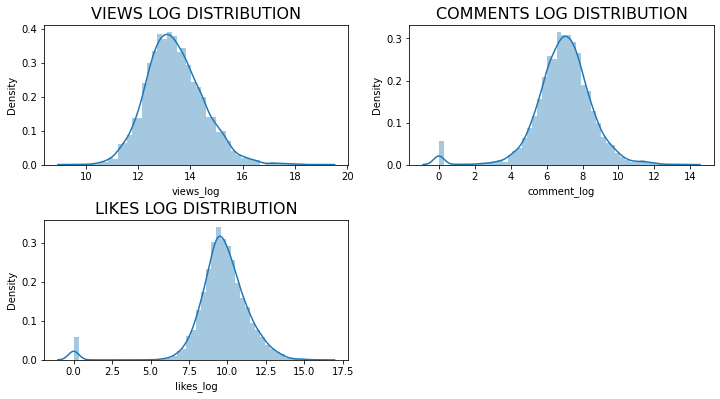

In [ ]:
plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(df_yout['views_log'])
g1.set_title("VIEWS LOG DISTRIBUTION", fontsize=16)

plt.subplot(223)
g2 = sns.distplot(df_yout['likes_log'])
g2.set_title('LIKES LOG DISTRIBUTION', fontsize=16)

plt.subplot(222)
g4 = sns.distplot(df_yout['comment_log'])
g4.set_title("COMMENTS LOG DISTRIBUTION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)
plt.show()


# **Distribution of publishing hour by video count**

## **Extract the hour value of datetime**

In [ ]:
hour = []
for date in df_yout['publishedAt']:
  tempHour = (date.split("T")[1].split(":"))[0]
  hour.append(tempHour)
df_yout['publishing_hour'] = hour
df_yout['publishing_hour'] = df_yout['publishing_hour'].astype(int)
print(df_yout['publishing_hour'].value_counts()[:5])

9     513
10    411
11    378
12    271
15    269
Name: publishing_hour, dtype: int64


## **Plotting the graph**

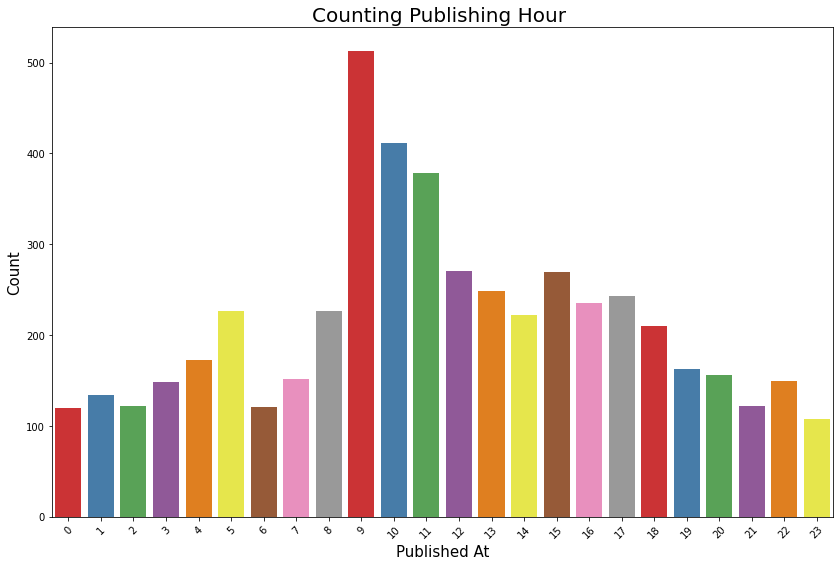

In [ ]:
plt.figure(figsize = (14,9))

g = sns.countplot('publishing_hour', data=df_yout, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Publishing Hour ", fontsize=20)
g.set_xlabel("Published At", fontsize=15)
g.set_ylabel("Count", fontsize=15)

plt.show()

Hypothesis: Publishing hour affect trending ability of a video

=> Conclusion: It can be seen from the chart that posting a video from 9 to 11 can increase the odd of making a video trending higher while on the other hand, publishing a video at late night or early morning will bring down the chance of getting to trending page. The hypothesis is correct.

# **Looking the views, likes, comments distribution by category_name's**

In [ ]:
df_yout['category_name'] = np.nan

df_yout.loc[(df_yout["categoryId"] == 1),"category_name"] = 'Film & Animation'
df_yout.loc[(df_yout["categoryId"] == 2),"category_name"] = 'Autos & Vehicles'
df_yout.loc[(df_yout["categoryId"] == 10),"category_name"] = 'Music'
df_yout.loc[(df_yout["categoryId"] == 15),"category_name"] = 'Pets & Animals'
df_yout.loc[(df_yout["categoryId"] == 17),"category_name"] = 'Sports'
df_yout.loc[(df_yout["categoryId"] == 18),"category_name"] = 'Short Movies'
df_yout.loc[(df_yout["categoryId"] == 19),"category_name"] = 'Travel and Events'
df_yout.loc[(df_yout["categoryId"] == 20),"category_name"] = 'Gaming'
df_yout.loc[(df_yout["categoryId"] == 21),"category_name"] = 'Videoblogging'
df_yout.loc[(df_yout["categoryId"] == 22),"category_name"] = 'People and Blogs'
df_yout.loc[(df_yout["categoryId"] == 23),"category_name"] = 'Comedy'
df_yout.loc[(df_yout["categoryId"] == 24),"category_name"] = 'Entertainment'
df_yout.loc[(df_yout["categoryId"] == 25),"category_name"] = 'News & Politics'
df_yout.loc[(df_yout["categoryId"] == 26),"category_name"] = 'Howto & Style'
df_yout.loc[(df_yout["categoryId"] == 27),"category_name"] = 'Education'
df_yout.loc[(df_yout["categoryId"] == 28),"category_name"] = 'Science & Technology'
df_yout.loc[(df_yout["categoryId"] == 30),"category_name"] = 'Movies'
df_yout.loc[(df_yout["categoryId"] == 31),"category_name"] = 'Anime/Animation'
df_yout.loc[(df_yout["categoryId"] == 32),"category_name"] = 'Action/Adventure'
df_yout.loc[(df_yout["categoryId"] == 33),"category_name"] = 'Classics'
df_yout.loc[(df_yout["categoryId"] == 34),"category_name"] = 'Comedy'
df_yout.loc[(df_yout["categoryId"] == 35),"category_name"] = 'Documentary'
df_yout.loc[(df_yout["categoryId"] == 36),"category_name"] = 'Drama'
df_yout.loc[(df_yout["categoryId"] == 37),"category_name"] = 'Family'
df_yout.loc[(df_yout["categoryId"] == 38),"category_name"] = 'Foreign'
df_yout.loc[(df_yout["categoryId"] == 39),"category_name"] = 'Horror'
df_yout.loc[(df_yout["categoryId"] == 40),"category_name"] = 'Sci-Fi/Fantasy'
df_yout.loc[(df_yout["categoryId"] == 41),"category_name"] = 'Thriller'
df_yout.loc[(df_yout["categoryId"] == 42),"category_name"] = 'Shorts'
df_yout.loc[(df_yout["categoryId"] == 43),"category_name"] = 'Shows'
df_yout.loc[(df_yout["categoryId"] == 44),"category_name"] = 'Trailers'


## **Views distribution by category_name's**

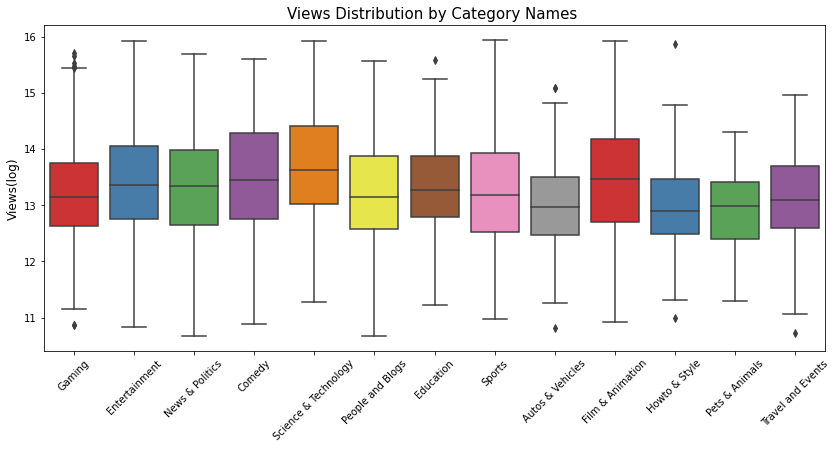

In [ ]:
plt.figure(figsize = (14,6))

g = sns.boxplot(x='category_name', y='views_log', data=df_yout, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Views Distribution by Category Names ", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Views(log)", fontsize=12)
plt.show()

## **Likes distribution by category_name's**

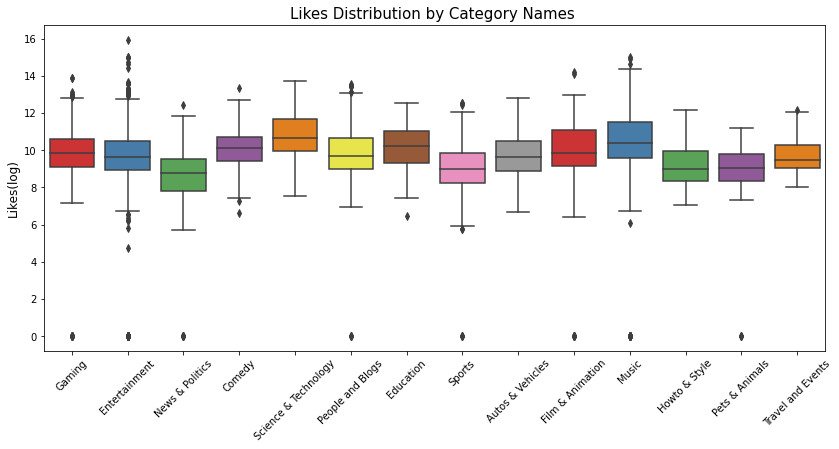

In [ ]:
plt.figure(figsize = (14,6))

g = sns.boxplot(x='category_name', y='likes_log', data=df_yout, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Likes Distribution by Category Names ", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Likes(log)", fontsize=12)
plt.show()

## **Comments distribution by category_name's**

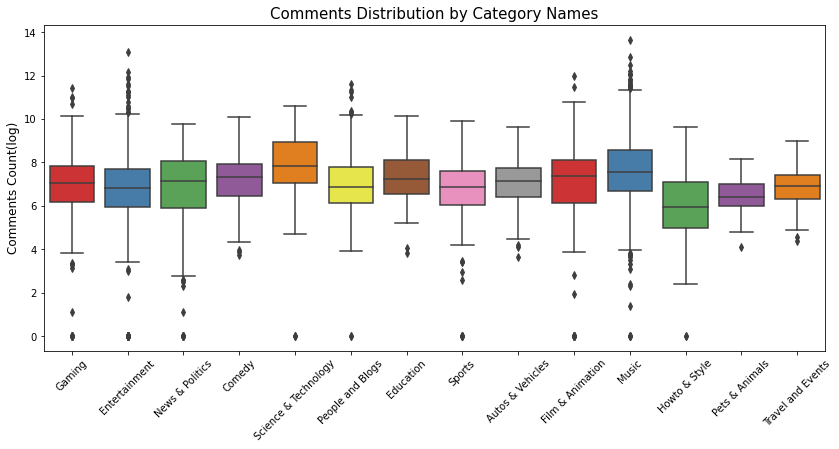

In [ ]:
plt.figure(figsize = (14,6))

g = sns.boxplot(x='category_name', y='comment_log', data=df_yout, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Comments Distribution by Category Names", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Comments Count(log)", fontsize=12)

plt.show()

# **Analysing the Correlation Matrix of the numerical variables**

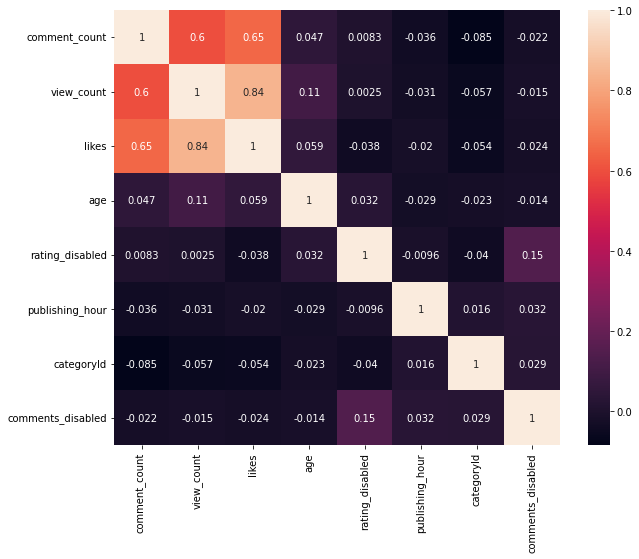

In [ ]:
plt.figure(figsize = (10,8))

#Let's verify the correlation of each value
sns.heatmap(df_yout[['comment_count', 'view_count', 'likes', 'age', 'rating_disabled', 'publishing_hour', 'categoryId', 'comments_disabled']].corr(), annot=True)
plt.show()

# **Analysing the word frequency of video title**

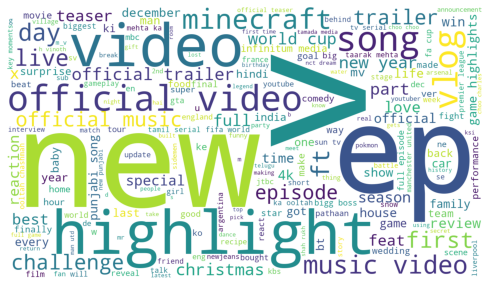

In [ ]:
# create empty string to hold all video titles later
text = ''
printable = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n'

# filter all the titles to leave only printable characters
df_yout['title'] = df_yout['title'].apply(
    lambda x: ''.join(filter(lambda xi: xi in printable, x)))
# get each video title, break the words into tokens and add to 'text'
for x in df_yout.index:
    title = str(df_yout.loc[x, 'title'])

    tokens = title.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    text += ' '.join(tokens)+' '

# generate word cloud
cloud = WordCloud(
    width=1400, height=800, background_color='white', min_font_size=12).generate(text)
# plot the word cloud
plt.figure(figsize=(8, 14), facecolor=None)
plt.imshow(cloud)
plt.axis("off")
plt.tight_layout(pad=5)
plt.show()

Hypothesis: Video's title can affect trending ability of the video.

=> Conclusion: Due to the differences in word frequency, it can be concluded that, to some extent, the keywords put in the video’s title can affect virality. The hypothesis is correct.

# **Analysing the average view needed for a video of a certain cartegories to trend**

In [ ]:
CATEGORIES = {1: 'Film & Animation',\
	2: 'Autos & Vehicles',\
	10: 'Music',\
	15: 'Pets & Animals',\
	17: 'Sports',\
	18: 'Short Movies',\
	19: 'Travel & Events',\
	20: 'Gaming',\
	21: 'Videoblogging',\
	22: 'People & Blogs',\
	23: 'Comedy',\
	24: 'Entertainment',\
	25: 'News & Politics',\
	26: 'Howto & Style',\
	27: 'Education',\
	28: 'Science & Technology',\
	29: 'Nonprofits & Activism',\
	30: 'Movies',\
	31: 'Anime/Animation',\
	32: 'Action/Adventure',\
	33: 'Classics',\
	34: 'Comedy',\
	35: 'Documentary',\
	36: 'Drama',\
	37: 'Family',\
	38: 'Foreign',\
	39: 'Horror',\
	40: 'Sci-Fi/Fantasy',\
	41: 'Thriller',\
	42: 'Shorts',\
	43: 'Shows',\
	44: 'Trailers'}

In [ ]:
# fill frequency table of categories
frequency = {}
for _, row in df_yout.iterrows():
    try:
        frequency[CATEGORIES[row['categoryId']]]['videos'] += 1
        frequency[CATEGORIES[row['categoryId']]
                  ]['views'] += row['view_count']
    except:
        frequency[CATEGORIES[row['categoryId']]] = {
            'videos': 1, 'views': row['view_count']}
sorted_frequency = dict(
    sorted(frequency.items(), key=lambda k_v: k_v[1]['videos'], reverse=True))

top_categories = dict(itertools.islice(sorted_frequency.items(), 8))

In [ ]:
# calculate average view counts
average = []
for category in top_categories.values():
    average.append(category['views'] // category['videos'])

dataset = pd.DataFrame(data={
    'categories': [*top_categories.keys()],
    'average_view_count': average,
})

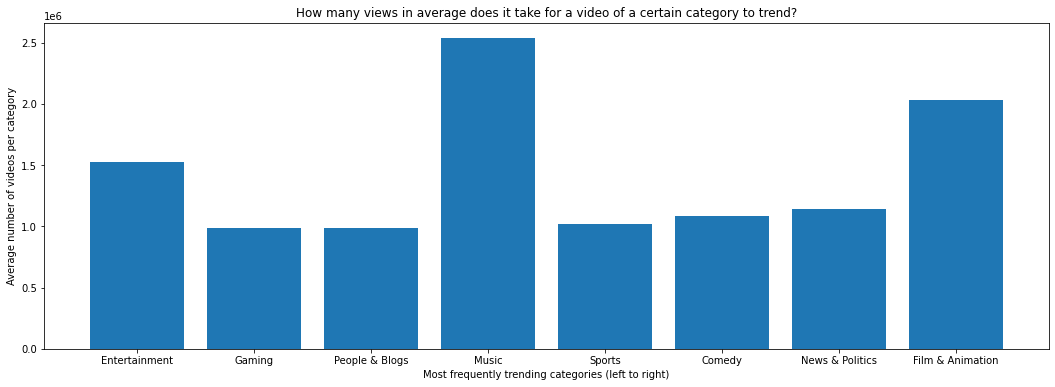

In [ ]:
# plot data
plt.figure(figsize = (18,6))
plt.bar(dataset['categories'], dataset['average_view_count'])
plt.xlabel('Most frequently trending categories (left to right)')
plt.ylabel('Average number of videos per category')
plt.title('How many views in average does it take for a video of a certain category to trend?')
# show plot
plt.show()

Hypothesis: View count required to trend are roughly the same across every category.

=> Conclusion: It's obvious that the view count needed to trend are different among different categories with Music needing the most amount of views, Film & Animation and Entertainment come close at second and third. So the hypothehis is wrong.

# **Check outliers of this dataset**

In [ ]:
df_yout.describe()

,Unnamed: 0,categoryId,view_count,likes,comment_count,age,likes_log,views_log,comment_log,publishing_hour
count,5121.000000,5121.000000,5.121000e+03,5.121000e+03,5121.000000,5121.000000,5121.000000,5121.000000,5121.000000,5121.000000
mean,3216.535052,19.837922,1.368740e+06,5.417753e+04,3715.933216,107.454599,9.648709,13.400379,6.939508,11.514548
std,1999.053777,6.253303,3.994886e+06,1.970892e+05,18471.269456,68.889151,1.886362,1.082574,1.616329,5.826615
min,0.000000,1.000000,1.347800e+04,0.000000e+00,0.000000,14.000000,0.000000,9.508888,0.000000,0.000000
25%,1505.000000,17.000000,3.149060e+05,7.391000e+03,456.000000,54.000000,8.908154,12.660033,6.124683,8.000000
50%,3053.000000,22.000000,6.023040e+05,1.627700e+04,1092.000000,91.000000,9.697570,13.308519,6.996681,11.000000
75%,4705.000000,24.000000,1.287275e+06,4.067300e+04,2576.000000,143.000000,10.613344,14.068039,7.854381,16.000000
max,7899.000000,29.000000,1.669460e+08,8.472237e+06,854011.000000,775.000000,15.952305,18.933181,13.657701,23.000000


In [ ]:
cols = []
for i in df_yout.columns:
    if(is_numeric_dtype(df_yout[i])):
        cols.append(i)
cols

['Unnamed: 0',
 'categoryId',
 'view_count',
 'likes',
 'comment_count',
 'comments_disabled',
 'age',
 'rating_disabled',
 'likes_log',
 'views_log',
 'comment_log',
 'publishing_hour']

In [ ]:
cols = ['categoryId', 'age', 'likes_log', 'views_log', 'comment_log', 'publishing_hour']

In [ ]:
def find_outliers(cols):
    plt.figure(figsize = (18,10))

    plt.subplot(231)
    g1 = sns.boxplot(data=df_yout[cols[0]], width=0.25, palette="Set1")
    g1.set_title("categoryId DISTRIBUTION", fontsize=12)

    plt.subplot(232)
    g1 = sns.boxplot(data=df_yout[cols[1]], width=0.25, palette="Set1_r")
    g1.set_title("age DISTRIBUTION", fontsize=12)

    plt.subplot(233)
    g1 = sns.boxplot(data=df_yout[cols[2]], width=0.25, palette="Set2")
    g1.set_title("likes LOG DISTRIBUTION", fontsize=12)

    plt.subplot(234)
    g1 = sns.boxplot(data=df_yout[cols[3]], width=0.25, palette="Set2_r")
    g1.set_title("VIEWS LOG DISTRIBUTION", fontsize=12)

    plt.subplot(235)
    g1 = sns.boxplot(data=df_yout[cols[4]], width=0.25, palette="Set3")
    g1.set_title("comment LOG DISTRIBUTION", fontsize=12)

    plt.subplot(236)
    g1 = sns.boxplot(data=df_yout[cols[5]], width=0.25, palette="Set3_r")
    g1.set_title("publishing_hour DISTRIBUTION", fontsize=12)

    plt.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.5, hspace = 0.6)

    plt.show()

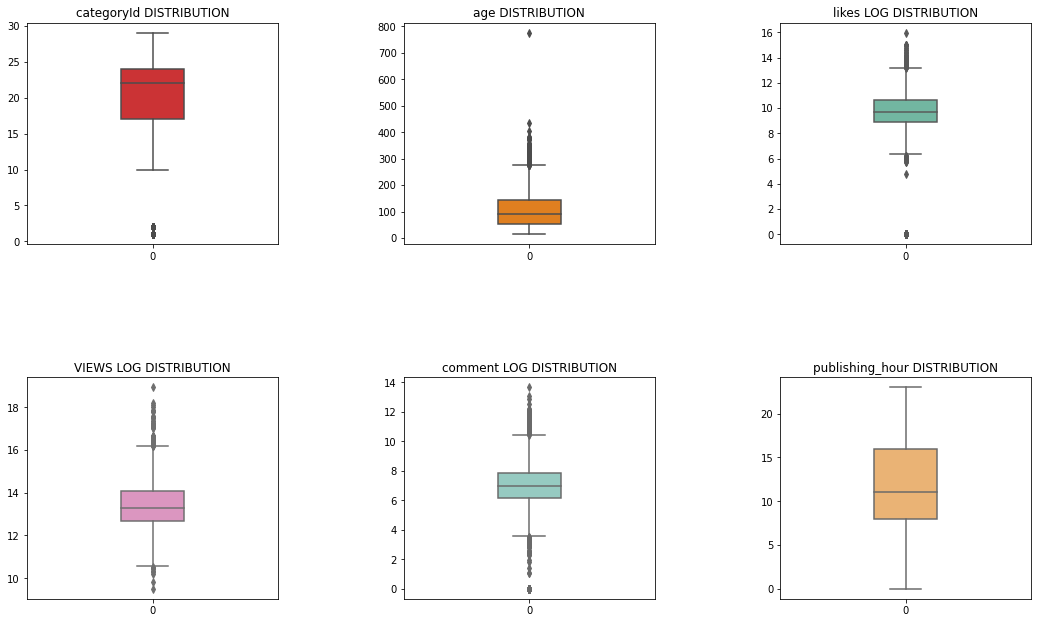

In [ ]:
find_outliers(cols=cols)

In [ ]:
def drop_outliers(df, field_names):
    print("before dropping outliers: {}".format(df_yout.shape[0]))
    for field_name in field_names:
        iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
        df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
        df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)
    print("after dropping outliers: {}".format(df_yout.shape[0]))

In [ ]:
def median_impute_outliers(df, field_names):
    print("before dropping outliers: {}".format(df_yout.shape[0]))
    for field_name in field_names:
        q1 = df_yout[field_name].quantile(0.25)
        q3 = df_yout[field_name].quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr
        med = np.median(df_yout[field_name])
        for i in df_yout[field_name]:
            if i > Upper_tail or i < Lower_tail:
                    df_yout[field_name] = df_yout[field_name].replace(i, med)
    print("after dropping outliers: {}".format(df_yout.shape[0]))

def zero_impute_outliers(df, field_names):
    print("before dropping outliers: {}".format(df_yout.shape[0]))
    for field_name in field_names:
        q1 = df_yout[field_name].quantile(0.25)
        q3 = df_yout[field_name].quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr
        for i in df_yout[field_name]:
            if i > Upper_tail or i < Lower_tail:
                    df_yout[field_name] = df_yout[field_name].replace(i, 0)
    print("after dropping outliers: {}".format(df_yout.shape[0]))

In [ ]:
median_impute_outliers(df_yout, cols)
drop_outliers(df_yout, cols)

before dropping outliers: 5121
after dropping outliers: 5121
before dropping outliers: 5121
after dropping outliers: 4366


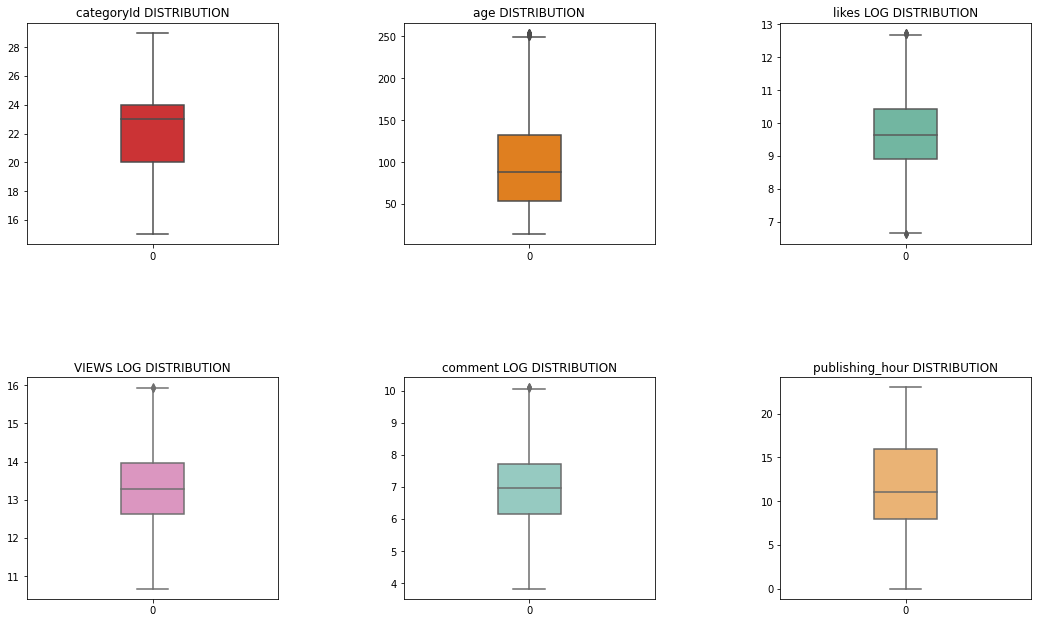

In [ ]:
find_outliers(cols=cols)

# **Predictive analysis of number of views for YouTube’s trending videos**

In [ ]:
df_yout.columns

Index(['Unnamed: 0', 'video_id', 'title', 'publishedAt', 'channelId',
       'channelTitle', 'categoryId', 'trending_date', 'view_count', 'likes',
       'comment_count', 'comments_disabled', 'description', 'age',
       'rating_disabled', 'likes_log', 'views_log', 'comment_log',
       'publishing_hour', 'category_name'],
      dtype='object')

In [ ]:
x_col = ['comment_count', 'likes', 'rating_disabled', 'age', 'publishing_hour']
y_col = ['view_count']

## **Metrics for evaluating regression model**

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
import numpy as np

def run_experiment(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Evaluation of model {}:".format(model))
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    print("\n")

## **Normalizing data**

In [ ]:
# train-test 70-30 split
df_train, df_test = train_test_split(df_yout, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)

In [ ]:
numeric_vars = ['age', 'comment_count', 'likes', 'view_count']

In [ ]:
def min_max_scaler(df_train, df_test, numeric_vars):
    
    # rescale the features for Linear Regression
    scaler = MinMaxScaler()

    # apply scaler() to all the numeric columns 
    df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
    df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])

    return df_train, df_test

In [ ]:
def standard_scaler(df_train, df_test, numeric_vars):

    # rescale the features for Linear Regression
    scaler = StandardScaler()

    # apply scaler() to all the numeric columns 
    df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
    df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
    
    return df_train, df_test

In [ ]:
df_train_min_max, df_test_min_max = min_max_scaler(df_train, df_test, numeric_vars)
df_train_standard, df_test_standard = standard_scaler(df_train, df_test, numeric_vars)

## **Train-Test-Split**

In [ ]:
def split_dataset(df_train, df_test, x_col, y_col):

    X_train = np.array(df_train[x_col]).reshape(-1, len(x_col))
    y_train = np.array(df_train[y_col]).reshape(-1, 1)

    X_test = np.array(df_test[x_col]).reshape(-1, len(x_col))
    y_test = np.array(df_test[y_col]).reshape(-1, 1)

    print((X_train.shape, y_train.shape), (X_test.shape, y_test.shape))
    return (X_train, y_train), (X_test, y_test)

In [ ]:
(X_train_min_max, y_train_min_max), (X_test_min_max, y_test_min_max) = split_dataset(df_train_min_max, df_test_min_max, x_col, y_col)
(X_train_standard, y_train_standard), (X_test_standard, y_test_standard) = split_dataset(df_train_standard, df_test_standard, x_col, y_col)

((3056, 5), (3056, 1)) ((1310, 5), (1310, 1))
((3056, 5), (3056, 1)) ((1310, 5), (1310, 1))


## **Running Experiment**

In [ ]:
run_experiment(LinearRegression(), X_train_min_max, y_train_min_max, X_test_min_max, y_test_min_max)
run_experiment(SGDRegressor(), X_train_standard, y_train_standard, X_test_standard, y_test_standard)

Evaluation of model LinearRegression():
R^2 :  0.8475076071557255
MAE : 0.1932841872022419
RMSE: 0.39050274370902255


Evaluation of model SGDRegressor():
R^2 :  0.8345848573394927
MAE : 0.20919607543291935
RMSE: 0.4067126045016398


